In [1]:
import numpy as np
from sympy import Eq, symbols, diff, Derivative as D, Function, sqrt as sqrt_, Abs as abs_, solve
from math import sqrt
from scipy.stats import norm
from matplotlib import pyplot as plt

# AMM Gamma vs Derivatives Gamma


## Setup

In [2]:
def gamma_gain(p0, p1, N=1):
    """
    how much an arbitrageurs makes on the gamma 
    
    :p0:         price before move
    :p1:         price after move
    :N:          notional
    :returns:    p1-sqrt(p0*p1) if p1 > p0, else sqrt(p0*p1)-p0
    """
    return N*abs(p1-sqrt(p0*p1))
    #return N*(p1-sqrt(p0*p1)) if p1 > p0 else N*(sqrt(p0*p1)-p1)
    
def fee_payment(fee, p1, N=1):
    """
    how much fees to be paid on a transaction
    
    :fee:        percentage fee
    :p1:         price after move
    :N:          notional
    :returns:    fee*N*p1
    """
    return fee*N*p1

def apply(func, rg):
    """
    applies `func` to `rg` and returns result as np.array
    
    equivalent to `lambda f,r: np.array([f(x) for x in r])`
    """
    return np.array([func(x) for x in rg])
A=apply

## Formulas

In [3]:
x_ = symbols("x")

In [4]:
diff(diff(  0.5*(x_-1)**2  , x_), x_).subs(x_,1)

1.00000000000000

In [5]:
diff(diff(  4*((1+x_)-sqrt_(x_))  , x_), x_).subs(x_,1)

1

## Analysis

In [6]:
square_f = lambda x: 0.5*(x-1)**2
hedged_f = lambda x: 4*((1+x)/2 - sqrt(x))
amm_f = lambda x: gamma_gain(1,x,0.75)
x_r = np.linspace(0.000001,2,100)
t_r = np.linspace(min(x_r)**2,max(x_r)**2,1000)
t2_r = np.linspace(min(x_r)**2,1**2,100)

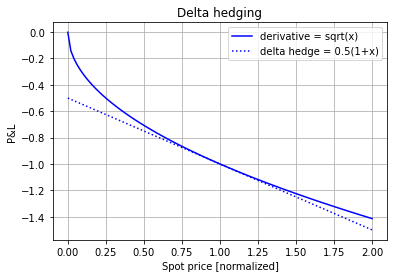

In [7]:
plt.plot(x_r, A(lambda x: -sqrt(x), x_r), color="blue", label="derivative = sqrt(x)")
plt.plot(x_r, A(lambda x: -0.5*(1+x), x_r), color="blue", linestyle="dotted", label="delta hedge = 0.5(1+x)")
plt.legend()
plt.title(f"Delta hedging")
plt.xlabel("Spot price [normalized]")
plt.ylabel("P&L")
plt.grid()

First we plot the `hedged` profile on its own. It corresponds to a hedged square root profile. We see that it is flat and looks quadratic around $x=1$. It is also the IL profile, which is not a coincidence. We also plotted the best-matching quadratic profile. The respective functions are given by

$$
PV_{hedged}(x) = \frac{1+x}{2} - \sqrt{x} \\
PV_{square}(x) = (x-1)^2
$$



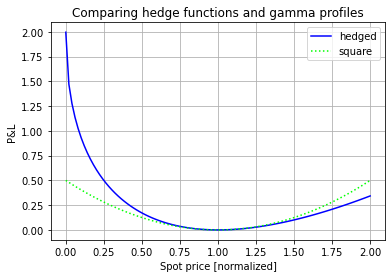

In [8]:
plt.plot(x_r, A(hedged_f, x_r), color="blue", label="hedged")
plt.plot(x_r, A(square_f, x_r), color="lime", linestyle="dotted", label="square")
plt.legend()
plt.title(f"Comparing hedge functions and gamma profiles")
plt.xlabel("Spot price [normalized]")
plt.ylabel("P&L")
plt.grid()

Then we plot the AMM profile on its own. It is the difference between the current market price $x$ and the geometric average between the current price and the old price $x_{old}=1$, because we know that an AMM always trades at this price when markets move. We see that it is linear around its cusp.

$$
PV_{amm}(x) = |x-\sqrt{x\cdot 1}|
$$

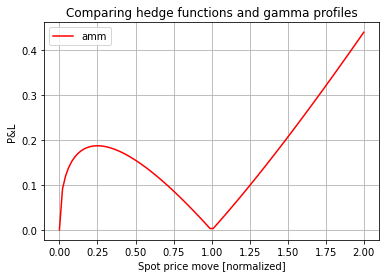

In [9]:
plt.plot(x_r, A(amm_f, x_r), color="red", label="amm")
plt.legend()
plt.title(f"Comparing hedge functions and gamma profiles")
plt.xlabel("Spot price move [normalized]")
plt.ylabel("P&L")
plt.grid()

Here we are looking at profiles that are hedged at $x=1$ where $x$ is some normalized spot value. The `hedged` profile is the square root profile which delta-hedged (which happens to be the classic IL profile as well), `amm` is the profile that is created by the AMM arbitrage flow (trade at $\sqrt{x_{old}x}$ when prices are at $x$), and `square` is pure quadratic payoff profile for reference.

The notional amounts have been chosen to roughly balance the charts, but there is no strict size relationship between the three profiles.

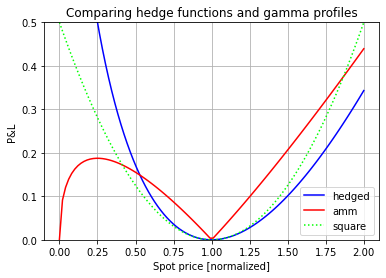

In [10]:
plt.plot(x_r, A(hedged_f, x_r), color="blue", label="hedged")
plt.plot(x_r, A(amm_f, x_r), color="red", label="amm")
plt.plot(x_r, A(square_f, x_r), color="lime", linestyle="dotted", label="square")
plt.legend()
plt.title(f"Comparing hedge functions and gamma profiles")
plt.xlabel("Spot price [normalized]")
plt.ylabel("P&L")
plt.ylim(0,0.5)
plt.grid()

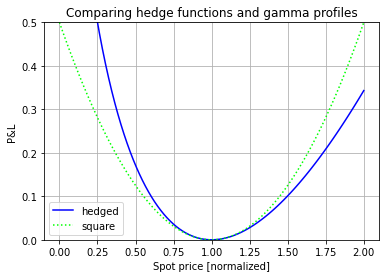

In [11]:
plt.plot(x_r, A(hedged_f, x_r), color="blue", label="hedged")
#plt.plot(x_r, A(amm_f, x_r), color="red", label="amm")
plt.plot(x_r, A(square_f, x_r), color="lime", linestyle="dotted", label="square")
plt.legend()
plt.title(f"Comparing hedge functions and gamma profiles")
plt.xlabel("Spot price [normalized]")
plt.ylabel("P&L")
plt.ylim(0,0.5)
plt.grid()

We now perform the break-even analysis: we use a time-like variable $\tau$ that represents rebalancing frequency and we assume that $\Delta x\simeq \sqrt{\tau}$ (volatility has been integrated into the scale of $\tau$. Rather than doing a full Monte Carlo we simply assume a one standard deviation move upwards in a time period tau, hence the $\sqrt{\tau}$ term. We then need to divide by $\tau$ to take into account for the fact that the smaller $\tau$, the more often the rebalancing happens.

We see the `square` profile is flat as it should be: on a perfect square profile, rebalancing frequency does not matter, as the $x^2$ is balanced by the $\sqrt{\tau}$ size of the moves. For the `hedged` profile we see that rebalancing frequency does matter, but not much. The reason for this is higher order terms, as the profile is not fully quadratic. For the `amm` profile finally we find a massive divergence for high-frequency rebalancing (ie $\tau\simeq 0$) because the growth of this profile around the pivot point $x=1$ is not quadratic but linear.

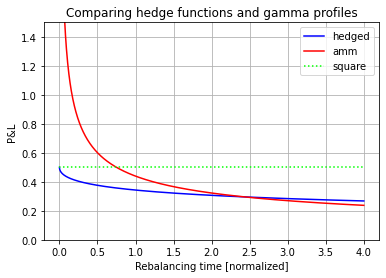

In [12]:
E = lambda f,t: 0.5*(f(1+sqrt(t))+f(1+sqrt(t))) # EV under binary distribution(mean=1, sdev=sqrt(t))

plt.plot(t_r, A(lambda t: E(hedged_f,t) / t, t_r), color="blue", label="hedged")
plt.plot(t_r, A(lambda t: E(amm_f,t) / t, t_r), color="red", label="amm")
plt.plot(t_r, A(lambda t: E(square_f,t) / t, t_r), color="lime", linestyle="dotted", label="square")
plt.legend()
plt.title(f"Comparing hedge functions and gamma profiles")
plt.xlabel("Rebalancing time [normalized]")
plt.ylabel("P&L")
plt.ylim(0,1.5)
plt.grid()

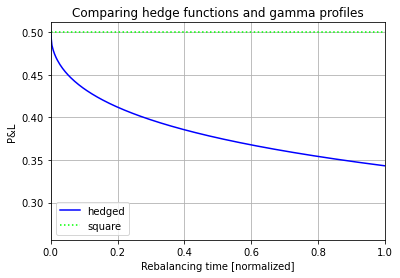

In [13]:
plt.plot(t_r, A(lambda t: E(hedged_f,t) / t, t_r), color="blue", label="hedged")
#plt.plot(t_r, A(lambda t: E(amm_f,t) / t, t_r), color="red", label="amm")
plt.plot(t_r, A(lambda t: E(square_f,t) / t, t_r), color="lime", linestyle="dotted", label="square")
plt.legend()
plt.title(f"Comparing hedge functions and gamma profiles")
plt.xlabel("Rebalancing time [normalized]")
plt.ylabel("P&L")
plt.xlim(0,1)
plt.grid()

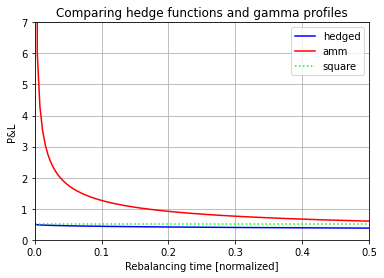

In [14]:
E = lambda f,t: 0.5*(f(1+sqrt(t))+f(1+sqrt(t))) # EV under binary distribution(mean=1, sdev=sqrt(t))

plt.plot(t_r, A(lambda t: E(hedged_f,t) / t, t_r), color="blue", label="hedged")
plt.plot(t_r, A(lambda t: E(amm_f,t) / t, t_r), color="red", label="amm")
plt.plot(t_r, A(lambda t: E(square_f,t) / t, t_r), color="lime", linestyle="dotted", label="square")
plt.legend()
plt.title(f"Comparing hedge functions and gamma profiles")
plt.xlabel("Rebalancing time [normalized]")
plt.ylabel("P&L")
plt.ylim(0,7)
plt.xlim(0,0.5)
plt.grid()

## Appendix - approximating the Normal distribution

Below is the binary approximation of the Normal distribution, ie it is a distribution that is non-zero at only two points (where the density is a Dira delta function) and that matches the normal distribution in expectation and variance. Because of Central Limit Theorem we know that this approximation is very powerful as soon as the number of independent draws is sufficiently big. It is the basis of the binomial tree method of option pricing, which was extremely popular far into the 90s when computing power was limited.

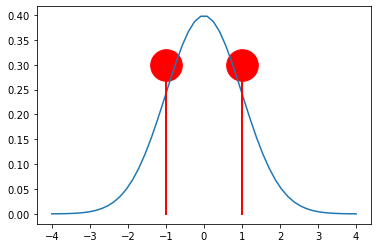

In [15]:
h = 0.3
x1_r = np.linspace(-4,4)
x2_r = [-1,-1,-1,-1, 1, 1,1,1]
y2_r = [0,h,0, None, None, 0,h,0]
plt.plot(x1_r, A(norm(0,1).pdf, x1_r))
plt.plot(x2_r, y2_r, color="red")
plt.scatter([-1,1], [h,h], s=1000, color="red")